In [2]:
import os
import torch
import transformers
import datasets
import huggingface_hub

import matplotlib.pyplot as plt
from tqdm import tqdm

### Initialization

In [3]:
datasets.disable_caching()

In [4]:
project_dir = '/Users/christopher/Documents/unireps'
# project_dir = '/net/scratch2/chriswolfram/unireps'
cache_dir = os.path.join(project_dir, 'hf_cache')
output_dir = os.path.join(project_dir, 'outputs')

In [5]:
def output_name(model_name, dataset_name):
    return '{}---{}'.format(model_name.replace('/', '__'), dataset_name)

def model_dataset_output(model_name, dataset_name):
    return datasets.load_from_disk(os.path.join(output_dir, output_name(model_name, dataset_name)))

def output_embeddings(ds, layer=-1, type='last', normalize=True):
    assert type == 'last' or type == 'mean'
    if type == 'last':
        key = 'layer_last_embeddings'
    elif type == 'mean':
        key = 'layer_mean_embeddings'

    if layer is None:
        embs = torch.stack([e[key] for e in ds]).permute(1,0,2)
    else:
        embs = torch.stack([e[key][layer] for e in ds])

    if normalize:
        embs = torch.nn.functional.normalize(embs, dim=-1)

    return embs

### Similarity measures

#### Mutual $k$-NN

In [6]:
def embs_knn(emb_mat, k):
    """
    Computes the k-nearest neighbors for each embedding in the given matrix using the dot product as the distance metric.
    Args:
        emb_mat (torch.Tensor): A 2D tensor where each row represents an embedding.
        k (int): The number of nearest neighbors to find for each embedding.
    Returns:
        torch.Tensor: A 2D tensor of shape (n, k) where n is the number of embeddings. Each row contains the indices of the k-nearest neighbors for the corresponding embedding.
    """

    gram = emb_mat @ emb_mat.T
    gram.fill_diagonal_(-torch.inf)

    return gram.topk(k, sorted=False).indices

def mutual_knn(knn_mat_1, knn_mat_2):
    """
    Computes the mutual k-nearest neighbors between two k-nearest neighbor matrices.

    Args:
        knn_mat_1 (torch.Tensor): A 2D tensor where each row contains the indices of the k-nearest neighbors for the first set of embeddings.
        knn_mat_2 (torch.Tensor): A 2D tensor where each row contains the indices of the k-nearest neighbors for the second set of embeddings.

    Returns:
        float: The proportion of mutual k-nearest neighbors between the two matrices.
    """

    assert knn_mat_1.shape == knn_mat_2.shape
    n = knn_mat_1.shape[0]
    k = knn_mat_1.shape[1]

    total = 0
    for i in range(n):
        total += torch.isin(knn_mat_1[i], knn_mat_2[i], assume_unique=True).sum()
    
    return (total / (k * n)).item()

def mutual_knn_baseline(n, k):
    """
    Calculate the mutual k-nearest neighbors baseline.

    This function returns the baseline probability of a mutual k-nearest neighbor
    in a dataset with `n` elements and `k` nearest neighbors.

    Parameters:
    n (int): The total number of elements in the dataset.
    k (int): The number of nearest neighbors to consider.

    Returns:
    float: The baseline probability of a mutual k-nearest neighbor.
    """
    return k / (n-1)

### Scatter plots

In [7]:
embs_1 = output_embeddings(model_dataset_output('google/gemma-2-2b', 'imdb').take(1024), -3, 'last', normalize=True)
embs_2 = output_embeddings(model_dataset_output('google/gemma-2-9b', 'imdb').take(1024), -3, 'last', normalize=True)

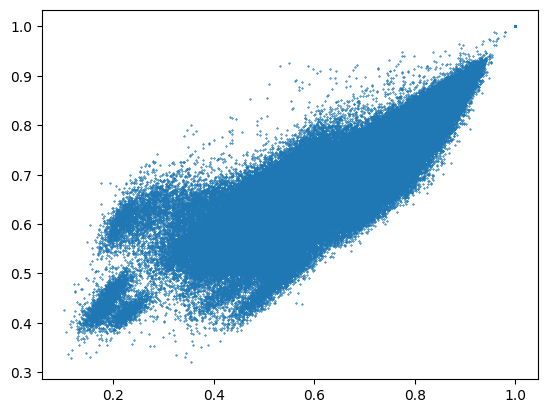

In [8]:
plt.scatter((embs_1 @ embs_1.T).flatten(), (embs_2 @ embs_2.T).flatten(), s=0.1)
plt.show()

### Identical embeddings

In [9]:
ds = model_dataset_output('google/gemma-2-2b', 'imdb').take(1024)
embs = output_embeddings(ds, -3, 'last', normalize=True)

In [10]:
(embs @ embs.T).fill_diagonal_(-torch.inf).flatten().topk(10).values

tensor([0.9803, 0.9803, 0.9802, 0.9802, 0.9784, 0.9784, 0.9663, 0.9663, 0.9635,
        0.9635])

In [11]:
flat_indices = torch.tensor([(a,b) for a in range(len(ds)) for b in range(len(ds))]).flatten(end_dim=-2)
top_indices = (embs @ embs.T).fill_diagonal_(-torch.inf).flatten().topk(10).indices
flat_indices[top_indices]

tensor([[767, 847],
        [847, 767],
        [184, 154],
        [154, 184],
        [619, 943],
        [943, 619],
        [812, 855],
        [855, 812],
        [812, 805],
        [805, 812]])

In [12]:
print(ds[167]['text'])
print(ds[168]['text'])

Written, produced and directed by Charlie Chaplin, this is the great actor's anti-Nazi propaganda piece, skewering Adolf Hitler.<br /><br />Chaplin plays Adenoid Hynckel, the dictator of Tomania, as well as a Jewish barber who is Hynckel's spitting image. His parody of Hitler is brilliant. Anyone who has ever seen newsreels of Hitler speaking will recognize the eerie resemblance of the caricature. <br /><br />I thought the movie got off to a slow start with some typical Chaplin slap-stick focussing on the First World War adventures of the Jewish barber. Having never seen it before I must confess that after the first 20 minutes or so I was wondering what all the fuss was about. But the movie picks up steam quickly. There are some very funny moments, and enough emphasis on the anti-Jewish nature of "Hynckel-ism" to make the propaganda point. The climax of the film is a brilliant anti-Nazi speech given by Chaplin at the end of the movie.<br /><br />As good as Chaplin is in this movie, tho

In [13]:
print(ds[66]['text'])
print(ds[836]['text'])

As far as fake documentaries go (fakumentaries anyone?), this one is up there with the best! It looks very real and that is what it aims for. In recent light of events (Guantanamo) this movie is even scarier, so you could say it was ahead of it's time, when it was released in the 70s! <br /><br />One can only hope that a government like that doesn't exist! Looking for terrorists and interviewing people just like that? Of course the people interviewed all seemed to have the same (70s mentality): Screw the politicians and politics in general. Maybe that wasn't so clever one might think ... but hey, don't forget: It's only a movie! ;o)
A whole bunch of teenagers gather around to discuss their fears, but an uninvited guest has showed up and is killing everybody off.<br /><br />Probably the worst horror film of the 90's, Camp Blood (1999) is the only film that could challenge it for that title, has some of the dumbest characters and situations to ever grace a television screen. The so calle

### Layer pair matrices

In [14]:
def layer_similarities(embs_1, embs_2, k):
    knn_1 = torch.stack([embs_knn(e, k) for e in embs_1])
    knn_2 = torch.stack([embs_knn(e, k) for e in embs_2])

    out = torch.zeros(len(knn_1), len(knn_2))
    for i in tqdm(range(len(knn_1))):
        for j in range(len(knn_2)):
            out[i,j] = mutual_knn(knn_1[i], knn_2[j])

    return out

def layer_similarities_plot(model_1, model_2, dataset, k=10, normalize=True, type='last', n=1024, show_max=False):
    embs_1 = output_embeddings(model_dataset_output(model_1, dataset).take(n), None, type, normalize=normalize)
    embs_2 = output_embeddings(model_dataset_output(model_2, dataset).take(n), None, type, normalize=normalize)
    ls = layer_similarities(embs_1, embs_2, k)

    fig = plt.figure()
    ax = fig.add_subplot()

    cax = ax.matshow(ls, vmin=0, vmax=1)
    fig.colorbar(cax, fraction=0.025)
    
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(model_2)
    ax.set_ylabel(model_1)

    if show_max:
        ax.plot(range(ls.shape[1]), ls.max(dim=0).indices, c='red')

    return fig

In [10]:
mutual_knn_baseline(1024, 10)

0.009775171065493646

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:33<00:00,  2.39it/s]


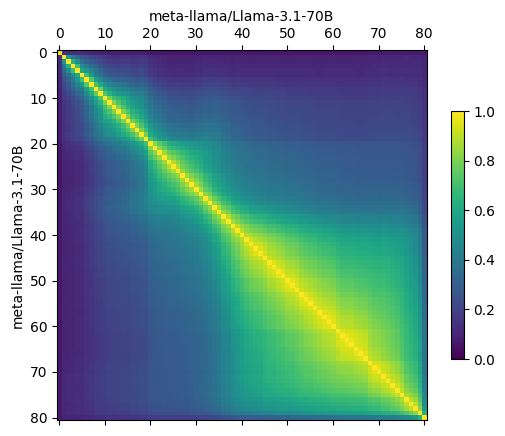

In [11]:
layer_similarities_plot('meta-llama/Llama-3.1-70B', 'meta-llama/Llama-3.1-70B', 'imdb')
plt.show()

100%|██████████| 27/27 [00:06<00:00,  4.48it/s]


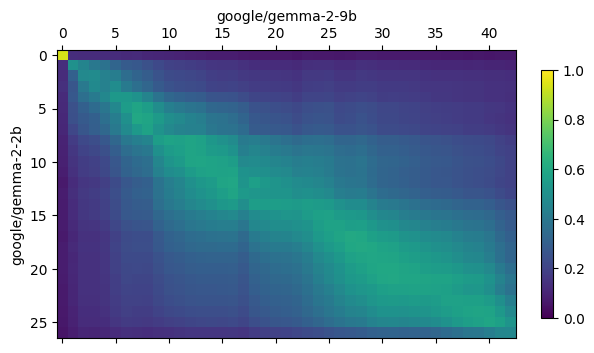

In [12]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'imdb')
plt.show()

100%|██████████| 27/27 [00:05<00:00,  4.58it/s]


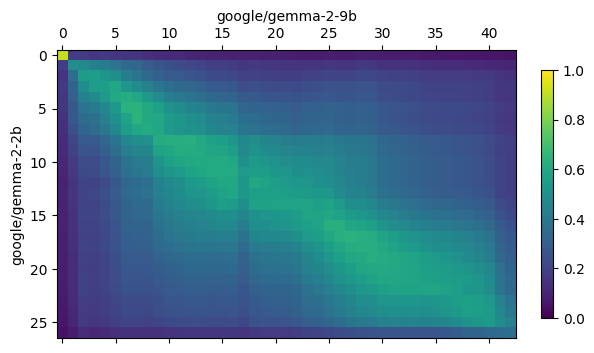

In [28]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'web_text')
plt.show()

100%|██████████| 27/27 [00:06<00:00,  4.41it/s]


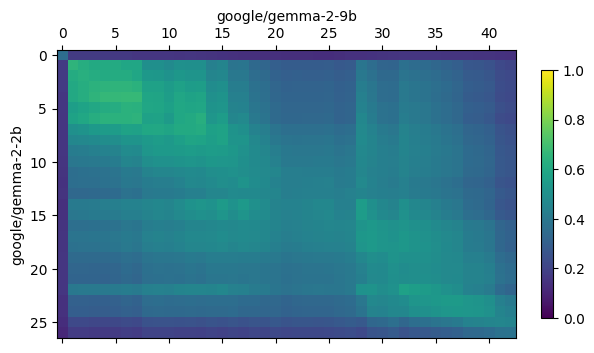

In [13]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'imdb_caesar')
plt.show()

100%|██████████| 27/27 [00:06<00:00,  4.40it/s]


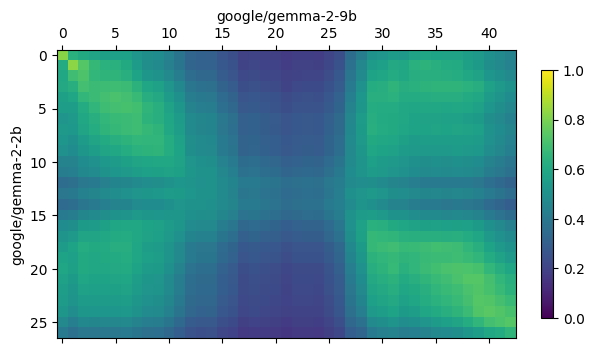

In [14]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'random_strings')
plt.show()

100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


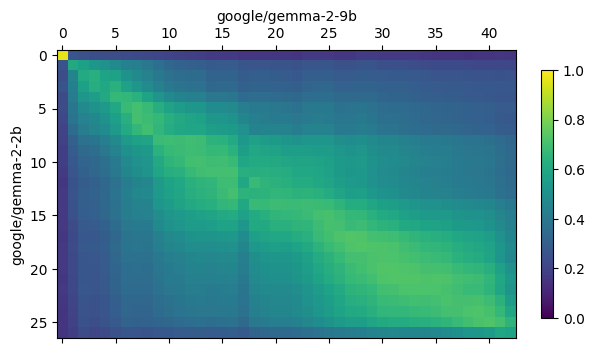

In [15]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'imdb', k=100)
plt.show()

100%|██████████| 27/27 [00:05<00:00,  4.65it/s]


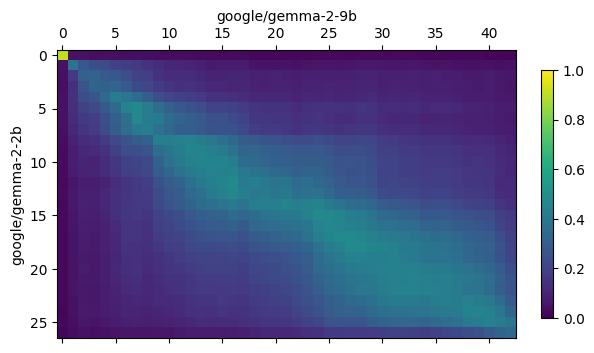

In [16]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'imdb', k=1)
plt.show()

100%|██████████| 27/27 [00:06<00:00,  4.39it/s]


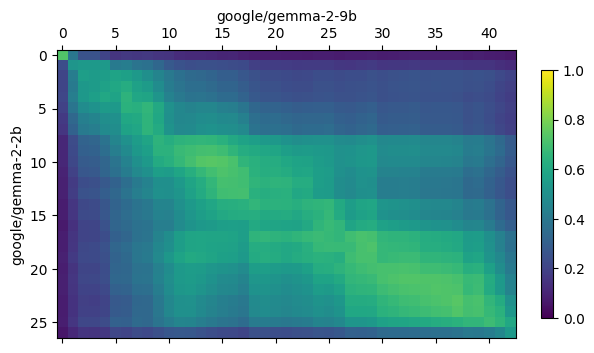

In [17]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'imdb', type='mean')
plt.show()

100%|██████████| 27/27 [00:06<00:00,  4.39it/s]


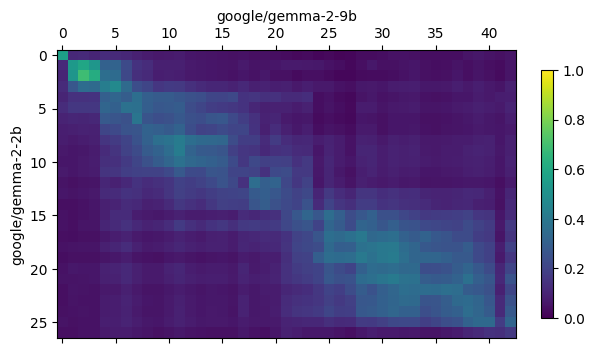

In [18]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-9b', 'imdb', normalize=False)
plt.show()

100%|██████████| 27/27 [00:06<00:00,  4.00it/s]


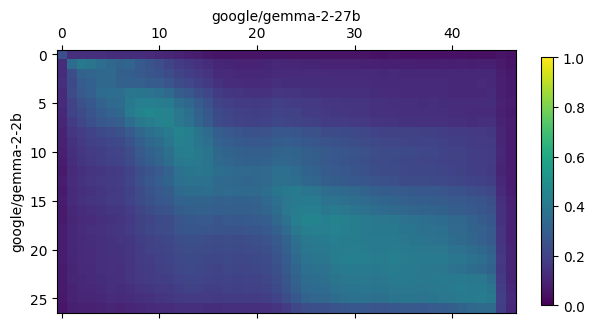

In [19]:
layer_similarities_plot('google/gemma-2-2b', 'google/gemma-2-27b', 'imdb')
plt.show()

100%|██████████| 43/43 [00:09<00:00,  4.49it/s]


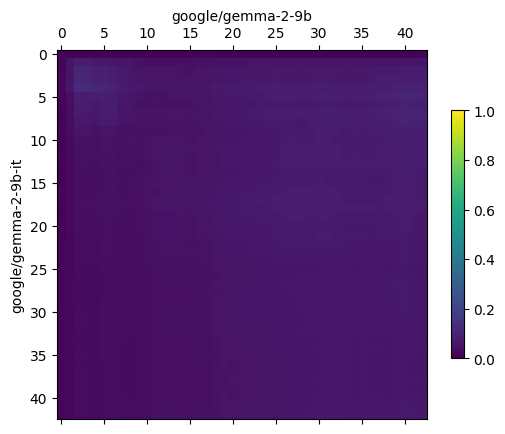

In [68]:
layer_similarities_plot('google/gemma-2-9b-it', 'google/gemma-2-9b', 'imdb')
plt.show()

100%|██████████| 43/43 [00:10<00:00,  4.02it/s]


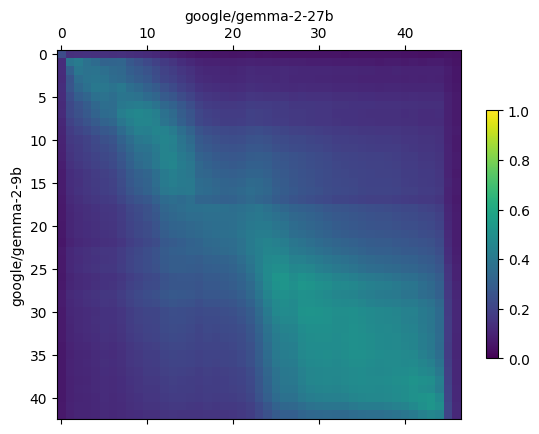

In [20]:
layer_similarities_plot('google/gemma-2-9b', 'google/gemma-2-27b', 'imdb')
plt.show()

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:11<00:00,  2.29it/s]


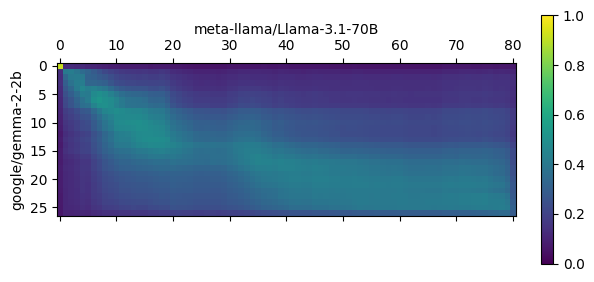

In [21]:
layer_similarities_plot('google/gemma-2-2b', 'meta-llama/Llama-3.1-70B', 'imdb')
plt.show()

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


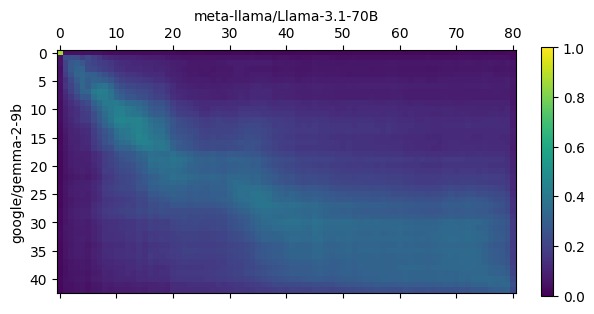

In [22]:
layer_similarities_plot('google/gemma-2-9b', 'meta-llama/Llama-3.1-70B', 'imdb', k=1)
plt.show()

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:13<00:00,  2.37it/s]


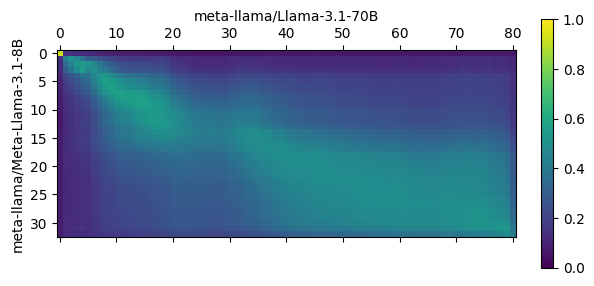

In [27]:
layer_similarities_plot('meta-llama/Meta-Llama-3.1-8B', 'meta-llama/Llama-3.1-70B', 'imdb')
plt.show()

100%|██████████| 27/27 [00:04<00:00,  5.74it/s]


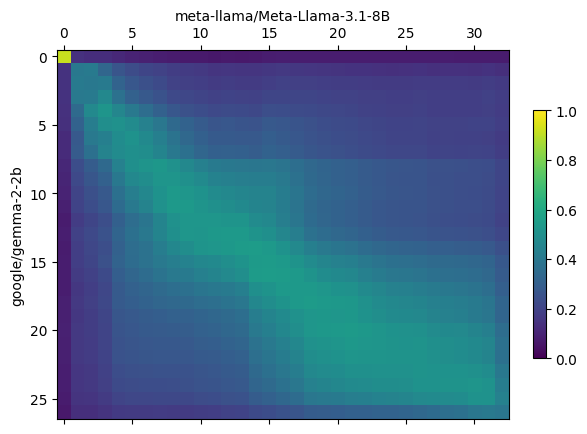

In [37]:
layer_similarities_plot('google/gemma-2-2b', 'meta-llama/Meta-Llama-3.1-8B', 'imdb')
plt.show()

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:18<00:00,  2.33it/s]


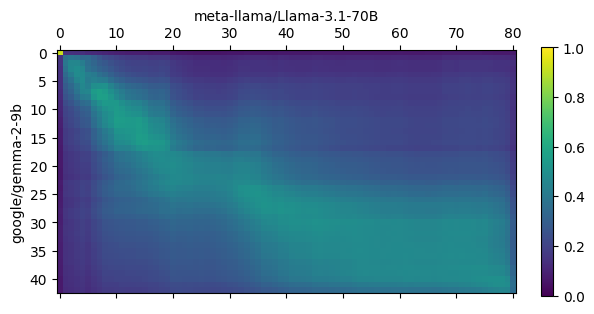

In [ ]:
layer_similarities_plot('google/gemma-2-9b', 'meta-llama/Llama-3.1-70B', 'imdb')
plt.show()

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:18<00:00,  2.36it/s]


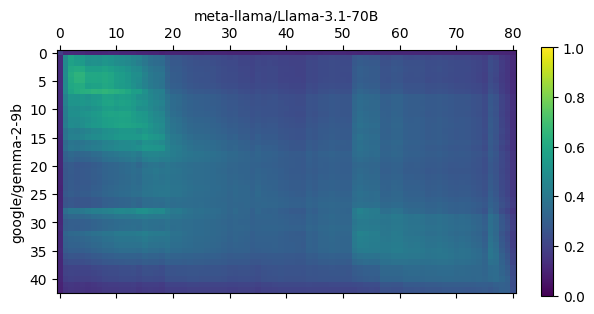

In [36]:
layer_similarities_plot('google/gemma-2-9b', 'meta-llama/Llama-3.1-70B', 'imdb_caesar')
plt.show()

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:13<00:00,  2.37it/s]


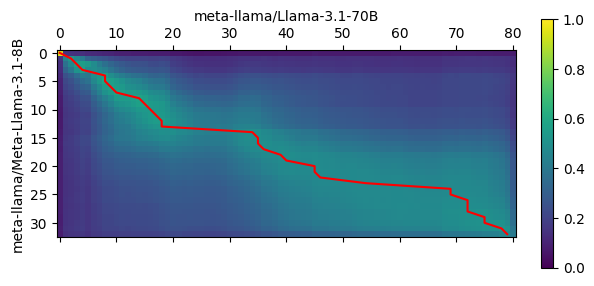

In [ ]:
layer_similarities_plot('meta-llama/Meta-Llama-3.1-8B', 'meta-llama/Llama-3.1-70B', 'imdb', show_max=True)
plt.show()

Loading dataset from disk:   0%|          | 0/33 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:25<00:00,  2.36it/s]


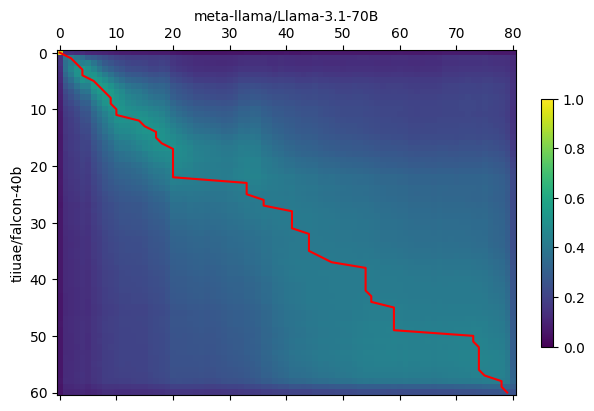

In [31]:
layer_similarities_plot('tiiuae/falcon-40b', 'meta-llama/Llama-3.1-70B', 'imdb', show_max=True)
plt.show()

Loading dataset from disk:   0%|          | 0/33 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:25<00:00,  2.38it/s]


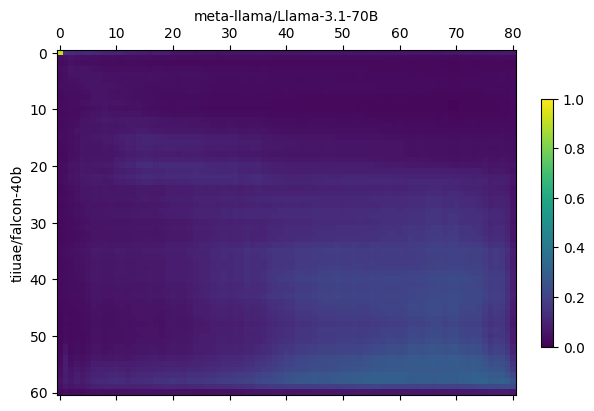

In [35]:
layer_similarities_plot('tiiuae/falcon-40b', 'meta-llama/Llama-3.1-70B', 'imdb', normalize=False)
plt.show()

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:14<00:00,  2.35it/s]


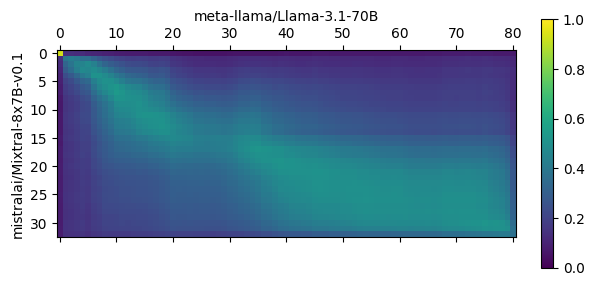

In [32]:
layer_similarities_plot('mistralai/Mixtral-8x7B-v0.1', 'meta-llama/Llama-3.1-70B', 'imdb')
plt.show()

100%|██████████| 33/33 [00:05<00:00,  6.00it/s]


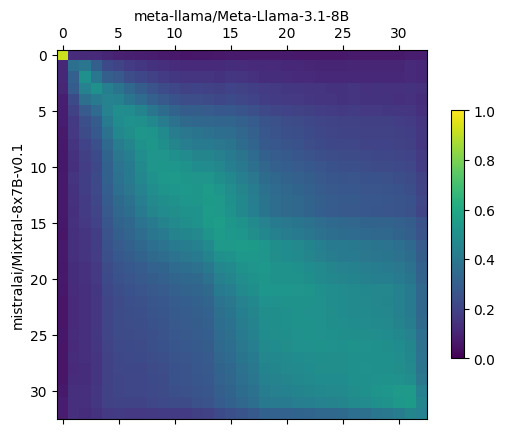

In [15]:
layer_similarities_plot('mistralai/Mixtral-8x7B-v0.1', 'meta-llama/Meta-Llama-3.1-8B', 'imdb')
plt.show()

### Nearest inputs sequences

In [ ]:
model_dataset_output(model, dataset).take(n)

In [42]:
model = 'google/gemma-2-2b'
dataset = 'web_text'
n = 1024
i = 10
dataset_output = model_dataset_output(model, dataset).take(n)
embs = output_embeddings(dataset_output, None, 'last', normalize=True)

In [43]:
nearest = []
for l in range(len(embs)):
    nearest.append(embs_knn(embs[l], 1)[i,0])
nearest = torch.tensor(nearest)

In [44]:
dataset_output[i]['text']

'CLOSE The Courier-Journal\'s Phillip M. Bailey talks with Louisville Mayor Greg Fischer to discuss one of the so-called "War on Louisville" bills.\n\nBuy Photo State Capitol (Photo: The Courier-Journal)Buy Photo\n\nAs Kentucky lawmakers prepare to convene for a 60-day session that will tackle pension reform and look to fill a $1 billion budget shortfall, Louisville leaders are wondering if more changes are planned for how the city\'s government is run.\n\nLouisville Democrats were apoplectic when the Republican-controlled legislature unveiled a series of bills in 2017 that amended the state law that merged city and county government. It was quickly dubbed a "war on Louisville" by opponents who saw it as conservative state lawmakers trying to neutralize the liberal-leaning city.\n\nOne of the most controversial proposals, which was eventually dropped, sought to give the governor the authority to appoint a new mayor or Metro Council member in the case of a vacancy. Mayor Greg Fischer re

In [46]:
for l in range(len(embs)):
    print(dataset_output[nearest[l].item()]['text'])
    print("################################")

A Colorado landlord faces a felony trespassing charge after a renter with a video security system caught the man having sex in his apartment.

An arrest warrant has been issued for Carlos Quijada of Colorado Springs. KKTV-TV (bit.ly/2gSyKEc) asked Quijada for comment on Wednesday afternoon, but the man drove away.

Logan Pierce says he received an alert on his phone from his security system, looked at the feed from the bedroom camera and said he was in complete and utter disbelief. He said he called his wife and told her they were going to have to move, then he called police and turned over the video evidence.

Police Lt. Howard Black said landlords don't have the right to go into tenant apartments and do whatever they want to do.

___

Information from: KKTV-TV, http://www.kktv.com/
################################
A Colorado landlord faces a felony trespassing charge after a renter with a video security system caught the man having sex in his apartment.

An arrest warrant has been is

### Model arrays

In [79]:
models = [
    'openai-community/gpt2',
    'google/gemma-2b',
    'google/gemma-7b',
    'google/gemma-2-2b',
    'google/gemma-2-9b',
    'google/gemma-2-9b-it',
    'google/gemma-2-27b',
    'meta-llama/Meta-Llama-3.1-8B',
    # 'meta-llama/Meta-Llama-3.1-8B-Instruct',
    'meta-llama/Llama-3.2-1B',
    'meta-llama/Llama-3.2-3B',
    # 'meta-llama/Llama-3.2-3B-Instruct',
    'meta-llama/Llama-3.2-11B-Vision',
    'mistralai/Mistral-7B-v0.3',
    'mistralai/Mistral-Nemo-Base-2407',
    'mistralai/Mixtral-8x7B-v0.1',
    # 'microsoft/Phi-3-mini-4k-instruct',
    # 'microsoft/Phi-3-medium-4k-instruct',
    # 'microsoft/Phi-3.5-mini-instruct',
    'tiiuae/falcon-40b',
    'tiiuae/falcon-11B',
    'meta-llama/Llama-3.1-70B',
    'meta-llama/Llama-3.1-70B-Instruct',
    # 'meta-llama/Llama-3.3-70B-Instruct',
    # 'tiiuae/falcon-mamba-7b'
]

model_layers = [(m, -3) for m in models]

In [80]:
n = 1024
k = 10
aggregation = 'last'
normalize = True
dataset = 'imdb'

model_layer_knns = []
for model, layer in tqdm(model_layers):
    embs = output_embeddings(model_dataset_output(model, dataset).take(n), layer, aggregation, normalize=normalize)
    knn = embs_knn(embs, k)
    model_layer_knns.append(knn)
    
model_layer_knns = torch.stack(model_layer_knns)

 78%|███████▊  | 14/18 [00:33<00:11,  2.83s/it]

Loading dataset from disk:   0%|          | 0/33 [00:00<?, ?it/s]

 83%|████████▎ | 15/18 [00:41<00:13,  4.39s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 89%|████████▉ | 16/18 [00:45<00:08,  4.27s/it]

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

 94%|█████████▍| 17/18 [00:56<00:06,  6.11s/it]

Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 18/18 [01:06<00:00,  3.69s/it]


In [81]:
model_layer_alignments = torch.zeros(len(model_layers), len(model_layers))
for i in tqdm(range(len(model_layers))):
    for j in range(len(model_layers)):
        model_layer_alignments[i,j] = mutual_knn(model_layer_knns[i], model_layer_knns[j])

100%|██████████| 18/18 [00:01<00:00, 10.50it/s]


In [82]:
model_layer_alignments

tensor([[1.0000, 0.2331, 0.1983, 0.2359, 0.2142, 0.0463, 0.1688, 0.2240, 0.2791,
         0.2427, 0.2270, 0.2294, 0.2325, 0.2200, 0.2019, 0.2053, 0.1967, 0.0410],
        [0.2331, 1.0000, 0.4862, 0.5397, 0.5226, 0.0691, 0.3774, 0.4788, 0.4655,
         0.5121, 0.4253, 0.4742, 0.4572, 0.4361, 0.3912, 0.4351, 0.3986, 0.0678],
        [0.1983, 0.4862, 1.0000, 0.5049, 0.5656, 0.0711, 0.4615, 0.5321, 0.4112,
         0.5070, 0.4501, 0.5070, 0.5105, 0.4913, 0.4250, 0.4947, 0.4885, 0.0707],
        [0.2359, 0.5397, 0.5049, 1.0000, 0.5781, 0.0636, 0.3849, 0.5205, 0.4922,
         0.5361, 0.4385, 0.5193, 0.4911, 0.4776, 0.3987, 0.4583, 0.4208, 0.0663],
        [0.2142, 0.5226, 0.5656, 0.5781, 1.0000, 0.0673, 0.4734, 0.5471, 0.4381,
         0.5368, 0.4694, 0.5517, 0.5468, 0.5311, 0.4557, 0.4993, 0.4919, 0.0705],
        [0.0463, 0.0691, 0.0711, 0.0636, 0.0673, 1.0000, 0.0607, 0.0725, 0.0633,
         0.0684, 0.0719, 0.0696, 0.0694, 0.0673, 0.0640, 0.0684, 0.0688, 0.1589],
        [0.1688, 0.377

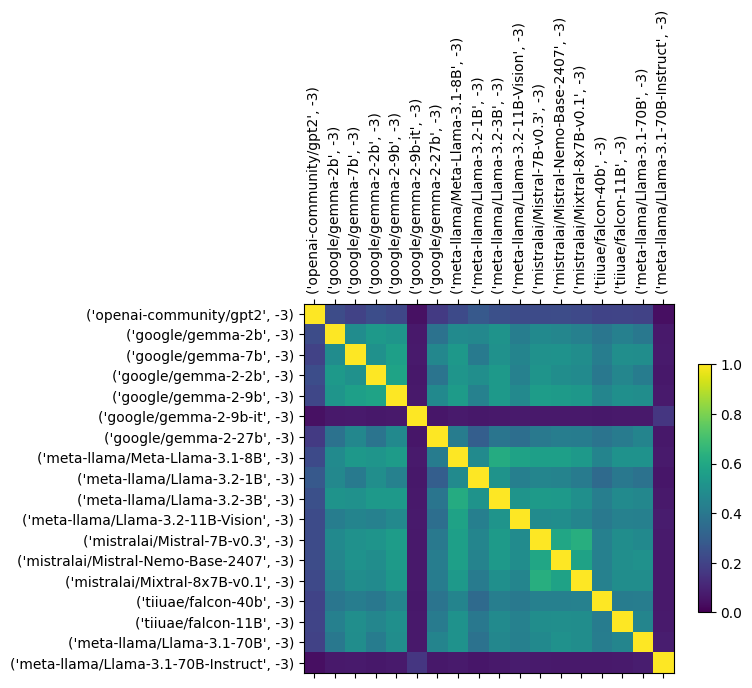

In [83]:
fig = plt.figure()
ax = fig.add_subplot()

cax = ax.matshow(model_layer_alignments, vmin=0, vmax=1)
fig.colorbar(cax, fraction=0.025)

ax.set_xticks(range(len(model_layers)))
ax.set_yticks(range(len(model_layers)))
ax.set_xticklabels(model_layers, rotation=90)
ax.set_yticklabels(model_layers)
plt.show()

### Experiments

In [140]:
embs_1 = output_embeddings(model_dataset_output('google/gemma-2-2b', 'imdb').take(1024), -3, 'last', normalize=True)
embs_2 = output_embeddings(model_dataset_output('google/gemma-2-9b', 'imdb').take(1024), -3, 'last', normalize=True)

In [151]:
knn_1 = embs_knn(embs_1, 10)
knn_2 = embs_knn(embs_2, 10)
mutual_knn(knn_1, knn_2)

0.5711914300918579

In [150]:
knn_1_permuted = embs_knn(embs_1[torch.randperm(len(embs_1))], 10)
knn_2 = embs_knn(embs_2, 10)
mutual_knn(knn_1_permuted, knn_2)

0.010937499813735485

In [43]:
imdb = datasets.load_dataset('stanfordnlp/imdb', split='train', cache_dir=cache_dir)

In [58]:
imdb.shuffle(seed=1234).take(4096)

Dataset({
    features: ['text', 'label'],
    num_rows: 4096
})